# 2. Sentiment Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict
import re

# import sklearn models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import LabelPowerset

# nlp libraries/api
import en_core_web_lg
from neuralcoref import Coref



In [4]:
import gensim
from gensim.test.utils import datapath
import pickle

# Load opinion lexicon
neg_file = open("neg_words.txt",encoding = "ISO-8859-1")
pos_file = open("pos_words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos

# Setup nltk corpora path and Google Word2Vec location
google_vec_file = 'GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(datapath(google_vec_file), binary=True)
# pickle.dump(word2vec, open("word2vec_google.pkl", 'wb'))
# word2vec = pickle.load(open("word2vec_google.pkl", 'rb'))

# load the Multi-label binarizer from previous notebook
mlb = pickle.load(open("mlb.pkl", 'rb'))

# load the fitted naive bayes model from previous notebook
LR_model1 = pickle.load(open("LR_model1.pkl", 'rb'))

In [6]:
# word embedding from word2vec will be used to supplement the LR model of aspect terms. 
word2vec.n_similarity(['food'], ["sushi"])

0.43649092

In [10]:

def check_similarity(aspects, word):
    similarity = []
    for aspect in aspects:
        similarity.append(word2vec.n_similarity([aspect], [word]))
    # set threshold for max value
    if max(similarity) > 0.30:
        return aspects[np.argmax(similarity)]
    else:
        return None

def assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred):
    '''
    function: takes in a sentiment dictionary and appends the aspect dictionary
    inputs: sent_dict is a Counter in the form Counter(term:sentiment value)
            aspect_sent is total sentiment tally
            terms_dict is dict with individual aspect words associated with sentiment
    output: return two types of aspect dictionaries: 
            updated terms_dict and aspect_sent
    '''
    aspects = ['ambience', 'food', 'price', 'service']
    
    
    
    # First, check word2vec
    for term in sent_dict:
        try:
            # The conditions for when to use the NB classifier as default vs word2vec
            if check_similarity(aspects, term.split()[-1]):
                terms_dict[check_similarity(aspects, term.split()[-1])][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[check_similarity(aspects, term.split()[-1])]["pos"] += sent_dict[term]
                else:
                    aspect_sent[check_similarity(aspects, term.split()[-1])]["neg"] += abs(sent_dict[term])
            elif (pred[0] == "anecdotes/miscellaneous"):
                continue
            elif (len(pred) == 1):
                terms_dict[pred[0]][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[pred[0]]["pos"] += sent_dict[term]
                else:
                    aspect_sent[pred[0]]["neg"] += abs(sent_dict[term])
            # if unable to classify via NB or word2vec, then put them in misc. bucket
            else:
                terms_dict["misc"][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent["misc"]["pos"] += sent_dict[term]
                else:
                    aspect_sent["misc"]["neg"] += abs(sent_dict[term])
        except:
            print(term, "not in vocab")
            continue
    return aspect_sent, terms_dict
    
    
def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''
    sentence = nlp(sentence)
    sent_dict = Counter()
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                sent_dict[token.head.text] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):                        
                        sent_dict[child.text] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.text)
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    noun = ""
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"): 
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.text
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.text + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return sent_dict

def classify_and_sent(sentence, aspect_sent, terms_dict):
    '''
    function: classify the sentence into a category, and assign sentiment
    note: aspect_dict is a parent dictionary with all the aspects
    input: sentence & aspect dictionary, which is going to be updated
    output: updated aspect dictionary
    '''
    # classify sentence with NB classifier
    predicted = LR_model1.predict([sentence])
    pred = mlb.inverse_transform(predicted)
    
    # get aspect names and their sentiment in a dictionary form
    sent_dict = feature_sentiment(sentence)
    
    # try to categorize the aspect names into the 4 aspects in aspect_dict
    aspect_sent, terms_dict = assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred[0])
    return aspect_sent, terms_dict

def replace_pronouns(text):
    coref.one_shot_coref(text)
    return coref.get_resolved_utterances()[0]

def split_sentence(text):
    '''
    splits review into a list of sentences using spacy's sentence parser
    '''
    
    bag_sentence = []
    start = 0
    global review
    review = nlp(review)
    for token in review:
        if token.sent_start:
            bag_sentence.append(review[start:(token.i-1)])
            start = token.i
        if token.i == len(review)-1:
            bag_sentence.append(review[start:(token.i+1)])
    return bag_sentence

# Remove special characters using regex
def remove_special_char(sentence):
    return re.sub(r"[^a-zA-Z0-9.',:;?]+", ' ', sentence)

def review_pipe(review, aspect_sent, terms_dict={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}):
    review = replace_pronouns(review)
    sentences = split_sentence(review)
    for sentence in sentences:
        sentence = remove_special_char(str(sentence))
        aspect_sent, terms_dict = classify_and_sent(sentence.lower(), aspect_sent, terms_dict)
    return aspect_sent, terms_dict

In [11]:
import spacy
nlp = spacy.load('en_core_web_sm')
# test code for feature sentiment
sentence= 'I came here with my friends on a Tuesday night. The sushi here is amazing. Our waiter was very helpful, but the music was terrible.'
feature_sentiment(sentence)

Counter({'sushi': 1, 'waiter': 1, 'music': -1})

In [12]:
# test code
terms_dict={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
aspect_sent={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
review = "Our waiter was not very helpful, and the music was terrible."
test1, test2 = review_pipe(review, aspect_sent, terms_dict)

In [81]:
test1, test2

({'ambience': Counter({'neg': 1}),
  'food': Counter(),
  'price': Counter(),
  'service': Counter({'neg': 1}),
  'misc': Counter()},
 {'ambience': Counter({'music': -1}),
  'food': Counter(),
  'price': Counter(),
  'service': Counter({'waiter': -1}),
  'misc': Counter()})

## Pipeline:  
for each review:  
1) replace pronouns using neural coref api  
2) split each review into sentences  
3) update aspect dictionary

# Load up Yelp data and test

In [145]:
yelp_restaurant = pd.read_csv("yelp_processed.csv")
keeps =['business_id','business_name','city','attributes','business_overall_stars','text','review_stars']
yelp_restaurant = yelp_restaurant[keeps]
SPizza = yelp_restaurant[(yelp_restaurant.business_name=='Secret Pizza') & (yelp_restaurant.city == 'Las Vegas')]
SPizza

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,business_id,business_name,city,attributes,business_overall_stars,text,review_stars
0,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,The pizza was okay. Not the best I've had. I p...,2
1,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,"came here on Monday, no line. its good, but no...",3
2,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,This place is truly a secret! Its so hidden t...,5
3,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,This SECRET PIZZA was a secret for about 5 st...,5
4,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,this is the BEST place to grab a quick slice o...,5
5,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,"Never heard about this ""Secret Pizza"" place bu...",5
6,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,Secret pizza is a hidden gem inside The Cosmop...,4
7,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,"this place is good, real good. the pizza in my...",4
8,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,"Mmmm. Reminds me of the pizza back in NYC, whe...",4
9,iCQpiavjjPzJ5_3gPD5Ebg,Secret Pizza,Las Vegas,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",4,This place is a hidden gem... literally hidden...,5


In [125]:
len(SPizza)

4078

In [114]:
terms_dict={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
aspect_sent={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
# modify for each restaurant
for review in SPizza.text:
    aspect_sent, terms_dict = review_pipe(review, aspect_sent, terms_dict)

biaggio not in vocab
peperoni not in vocab
3.25 not in vocab
meatlovers not in vocab
piemakers not in vocab
settobello not in vocab
d'un not in vocab
eastcoaster not in vocab
fugetdaboutit not in vocab
pepporoni not in vocab
sicilian not in vocab
4.50 not in vocab
shiek not in vocab
peperoni not in vocab
nyer not in vocab
dayam not in vocab
pbr not in vocab
50 not in vocab
peekza not in vocab
californians not in vocab
pizzaaaa not in vocab
kuz not in vocab
dayclub not in vocab
multo not in vocab
38 not in vocab
pbr not in vocab
riocotta not in vocab
selfies not in vocab
nexg not in vocab
yelper not in vocab
24hr not in vocab
daym not in vocab
sicilian not in vocab
sicilian not in vocab
itttttt not in vocab
garlicy not in vocab
mindblown not in vocab
jaleo not in vocab
28 not in vocab
to not in vocab
20 not in vocab
meatlovers not in vocab
sicilian not in vocab
yelper not in vocab
forgetaboutit not in vocab
100 not in vocab
nomnom not in vocab
choisissez not in vocab
12 not in vocab
sba

In [115]:
# final output aspect sentiment, which is the overall sentiment scores
aspect_sent

{'ambience': Counter({'pos': 454.75, 'neg': 150.0}),
 'food': Counter({'pos': 3422.125, 'neg': 892.0}),
 'price': Counter({'pos': 242.25, 'neg': 101.0}),
 'service': Counter({'pos': 351.5, 'neg': 159.0}),
 'misc': Counter({'neg': 38.5, 'pos': 66.5})}

In [120]:
# final output all the aspect terms
SPizza_terms = terms_dict

{'ambience': Counter({'fun': 12,
          'ness': 3,
          'game': 1,
          'counter': 2,
          'flavor': 27.5,
          'taste': 22.5,
          'women': -1,
          'break': 2,
          'craziness': -1,
          'texture': 5,
          'quality': 14,
          'place': 10.5,
          'games': 2,
          'seating': -22.5,
          'decor': 6,
          'spot': 14,
          'space': -3,
          'environment': 1,
          'people': 1,
          'oomph': -1,
          'location': 5.75,
          'indulgence': 1,
          'areas': 2,
          'stars': 2,
          'spicy': 1,
          'dining': 4,
          'lounge': 1,
          'banter': 1,
          'charm': 4,
          'vibe': 11,
          'cosmopolitan': 6,
          'ratings': 1,
          'area': 5,
          'music': -2,
          'breeze': 1,
          'pizza taste': 2,
          'style': 5.5,
          'this': 1,
          'tone': -1,
          'venue': 1,
          'blend': 4,
          'hole': 6,

In [121]:
# pickle the aspect terms and sentiment separately.
pickle.dump(aspect_sent, open("SPizza_sentiment.pkl", 'wb'))
pickle.dump(terms_dict, open("SPizza_dict.pkl", 'wb'))

In [123]:
SPizza_sent = pickle.load(open("SPizza_sentiment.pkl", 'rb'))
SPizza_terms = pickle.load(open("SPizza_dict.pkl", 'rb'))

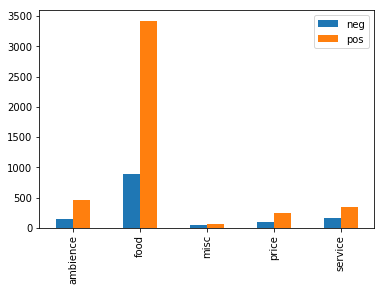

In [124]:
import matplotlib.pyplot as plt

# quick visualization
pd.DataFrame(SPizza_sent).T.plot(kind='bar')
plt.show()

In [158]:
primanti = yelp_restaurant[(yelp_restaurant.business_name=='Primanti Bros') & (yelp_restaurant.city == 'Pittsburgh')]
primanti

,business_id,business_name,city,attributes,business_overall_stars,text,review_stars
1024281,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,Primanti Brothers is definitely a Pittsburgh i...,2
1024282,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,This spot was the light of my life for about 3...,5
1024283,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,Definitely a fan of all their sandwiches. Wort...,4
1024284,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,"""Don't go there, it's touristy,"" native Pittsb...",4
1024285,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,Pittsburgh staple with good (but unhealthy) fo...,5
1024286,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,Alright so being from Texas I'm used to lots o...,2
1024287,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,Road tripped from Chicago for a conference and...,5
1024288,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,"Maybe the expectations were too high, but I ha...",2
1024289,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,We came for lunch and sat at the bar. The food...,5
1024290,w_UCGMgok7N9p0XdYBx1VQ,Primanti Bros,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,"This is pittsburgh, I eat her usually twice a ...",5


In [159]:
len(primanti)

1797

In [160]:
terms_dict={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
aspect_sent={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
# modify for each restaurant
for review in primanti.text:
    aspect_sent, terms_dict = review_pipe(review, aspect_sent, terms_dict)

xou not in vocab
sandwichs not in vocab
primanti not in vocab
primantis not in vocab
primanti not in vocab
primanti not in vocab
pittsburgher not in vocab
pittsburger not in vocab
pburgh not in vocab
pittsburgher not in vocab
primanti not in vocab
yiengling not in vocab
primanti not in vocab
primanti not in vocab
pittsburgher not in vocab
pittsburger not in vocab
primanti not in vocab
primanti not in vocab
primatis not in vocab
primanti not in vocab
primanti not in vocab
iiiiii not in vocab
mancinis not in vocab
olia not in vocab
primanti not in vocab
blt not in vocab
primantis not in vocab
primanti not in vocab
primanti not in vocab
sirlion not in vocab
primanti not in vocab
primanti not in vocab
primanti not in vocab
flavour not in vocab
kolbassi not in vocab
primantis not in vocab
primantis not in vocab
primanti not in vocab
capacolla not in vocab
sandwichs not in vocab
suause not in vocab
sandwitches not in vocab
gutbombs not in vocab
primanti not in vocab
primanti not in vocab
pri

In [161]:
pickle.dump(aspect_sent, open("primanti_sentiment.pkl", 'wb'))
pickle.dump(terms_dict, open("primanti_dict.pkl", 'wb'))

In [162]:
primanti_sent = pickle.load(open("primanti_sentiment.pkl", 'rb'))
primanti_terms = pickle.load(open("primanti_dict.pkl", 'rb'))

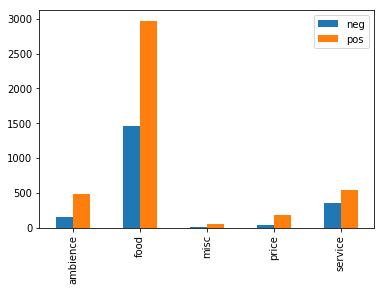

In [163]:
import matplotlib.pyplot as plt

# quick visualization
pd.DataFrame(primanti_sent).T.plot(kind='bar')
plt.show()

In [164]:
church_brew = yelp_restaurant[(yelp_restaurant.business_name=='Church Brew Works')& (yelp_restaurant.city == 'Pittsburgh')]
church_brew

,business_id,business_name,city,attributes,business_overall_stars,text,review_stars
259089,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,I came here for lunch and was rather disappoin...,2
259090,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,Solid joint. Beer is better than expected and...,4
259091,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,"I would go back again for the decor, but not t...",3
259092,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,"Did the flight, fantastic beers. The place is ...",4
259093,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,This is somewhere you go once.\n\nIt's awesome...,2
259094,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,"I'm not a beer drinker, so I can't comment on ...",4
259095,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,I had high expectations for this place as its ...,3
259096,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,"Great beer, bar tenders and atmosphere, food i...",4
259097,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,visiting the area from Oregon and this was on ...,5
259098,ejaUQ1hYo7Q7xCL1HdPINw,Church Brew Works,Pittsburgh,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",3.5,What a unique dining experience!!! This place ...,5


In [165]:
len(church_brew)

971

In [166]:
pickle.dump(aspect_sent, open("church_brew_sentiment.pkl", 'wb'))
pickle.dump(terms_dict, open("church_brew_dict.pkl", 'wb'))

In [167]:
church_brew_sent = pickle.load(open("church_brew_sentiment.pkl", 'rb'))
church_brew_terms = pickle.load(open("church_brew_dict.pkl", 'rb'))

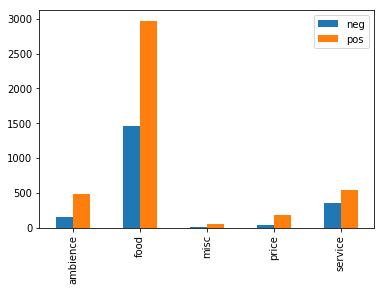

In [168]:
import matplotlib.pyplot as plt

# quick visualization
pd.DataFrame(church_brew_sent).T.plot(kind='bar')
plt.show()